# This notebook generates the following figures in our main paper
### Figure 3 Sequence of Prediction - Stable Case
### Figure 4 Final Predictions for all cases

## note: you need to generate dataset before running this notebook

## environment 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import time
import torch
torch.set_num_threads(1) 
torch.set_default_dtype(torch.float64)
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import math
import torch.optim as optim
from tqdm import tqdm
from torch.nn.parameter import Parameter
import sys
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print device
from collections import OrderedDict
import seaborn as sns
import pandas as pd
import itertools

cuda:0


In [2]:
path = os.getcwd() 
parent_path = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(parent_path)

## please generate stable case data and place your path here 

In [3]:
stabledata = '/home/takacMLGroup/DNN_FOR_PDEs/newData/data/case0_dt1.00e+00.tar'

## load stable case data

In [4]:
# remain the same across the board
from DataGenerator.DataGene import *
n = 10
x_max = np.pi
x_min = 0.0
num_x = 30
T_max = 1000.0
beta = 5000.0
IC = 200
generator = DataGene(device=device,n=n,x_max=x_max,x_min=x_min,num_x=num_x,T_max=T_max,beta=beta,IC=IC)


data_option = 0 # other cases need to change this
T_data = [200,400,600,800,1000]
T_plot = [200,400,600,800,1000]
dt = 1.0 
length = int(T_max/dt) # this is the time horizon

# place your data file location here
datafile = stabledata
wholedata = torch.load(datafile)

dataset = wholedata['data']
traindata = wholedata['train']
testdata = wholedata['test']

# normalize by adding 1.0
testdata[:,30,:]=0.0
testdata = testdata+1.0

x, _ = generator.DataForTest(testdata,length) 

testdata = torch.tensor(testdata-1.0,dtype=torch.float64,device=device).transpose(1,2)
real_signal = [testdata[:,0:1,:].data+0.0] # list of tensor

for t in T_data:
    real_signal.append(testdata[:,t:t+1,:].data+0.0)

## load TR and ADAM best results files 

In [5]:
stable_folder = parent_path+'/Pretrained/stable/'

In [6]:
TRdire = stable_folder+'TR/'
ADdire = stable_folder+'Adam/'
TRfile = TRdire+'file.tar'
ADfile = ADdire+'file.tar'
TRfilelist = torch.load(TRfile)['best']
ADfilelist = torch.load(ADfile)['best']
FR = [2,4,8,16]
FB = [1,2,3,4]

TRbest = []
A3best = []
A4best = []


TRend = []
A3end = []
A4end = []

for f in TRfilelist:
    TRbest.append(f)
        
for f in torch.load(TRfile)['result']:
    TRend.append(f)
    
for f in ADfilelist:
    if 'LR0.001_' in f:
        A3best.append(f)
    if 'LR0.0001' in f:
        A4best.append(f)

for f in torch.load(ADfile)['result']:    
    if 'LR0.001_' in f:
        A3end.append(f)
    if 'LR0.0001' in f:
        A4end.append(f)

## load model parameters associated with best runs by algorithms 

In [7]:
TR_err_best = np.inf
A3_err_best = np.inf
A4_err_best = np.inf

TR_best_parm = []
A3_best_parm = []
A4_best_parm = []

for f in TRbest:
    f = stable_folder+'TR/'+f
    if os.path.exists(f)==False:
        print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < TR_err_best:
        TR_err_best = temp['sqMSE'][-1]
        best_f = f
    
TR_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]


for f in A3best:
    f = stable_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A3_err_best:
        A3_err_best = temp['sqMSE'][-1]
        best_f = f
    
A3_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]




for f in A4best:
    f = stable_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A4_err_best:
        A4_err_best = temp['sqMSE'][-1]
        best_f = f
    
A4_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]

## Trust Region prediction 

In [8]:
from Models.FDNET import fdnet
xLen = 31


seed = TR_best_parm[1][0]
bs = TR_best_parm[1][1]
fdfilters = TR_best_parm[1][2]
fdblocks = TR_best_parm[1][3]
w0 = TR_best_parm[3]

print 'best run for TR: seed-%s, FD-Filters-%s, FD-Block-%s' %(seed,fdfilters,fdblocks)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

TR_pred_parm = [seed,bs,fdfilters,fdblocks]

# data used to plot
TR_pred = []

y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            TR_pred.append(y_pred.data.cpu().numpy())
            
print 'recorded 1000 steps MSE minimum: %.8e'%TR_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((TR_pred[4] - real_signal[5].cpu().numpy())**2)/50.0/31.0)

best run for TR: seed-2, FD-Filters-16, FD-Block-1
recorded 1000 steps MSE minimum: 3.17748025e-09
Calculated MSE minimum:          3.17748025e-09


## Adam 1e-3 prediction 

In [9]:
seed = A3_best_parm[1][0]
bs = A3_best_parm[1][1]
fdfilters = A3_best_parm[1][2]
fdblocks = A3_best_parm[1][3]
lr = A3_best_parm[1][4]
w0 = A3_best_parm[3]

print 'best run for A-1e-03: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A3_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
A3_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            A3_pred.append(y_pred.data.cpu().numpy())
            
print 'recorded 1000 steps MSE minimum: %.8e'%A3_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((A3_pred[4] - real_signal[5].cpu().numpy())**2)/50.0/31.0)

best run for A-1e-03: seed-9, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-03
recorded 1000 steps MSE minimum: 4.12830639e-06
Calculated MSE minimum:          4.12830639e-06


## Adam 1e-4 Prediction 

In [10]:
seed = A4_best_parm[1][0]
bs = A4_best_parm[1][1]
fdfilters = A4_best_parm[1][2]
fdblocks = A4_best_parm[1][3]
lr = A4_best_parm[1][4]
w0 = A4_best_parm[3]

print 'best run for A-1e-04: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A4_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
A4_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            A4_pred.append(y_pred.data.cpu().numpy())
            
print 'recorded 1000 steps MSE minimum: %.8e'%A4_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((A4_pred[4] - real_signal[5].cpu().numpy())**2)/50.0/31.0)

best run for A-1e-04: seed-9, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-04
recorded 1000 steps MSE minimum: 3.33157775e-05
Calculated MSE minimum:          3.33157775e-05


## Euler Prediction

In [11]:
if data_option == 3:
    dx_ = np.pi/30
    x_ = np.append([np.arange(0.0,np.pi,dx_)],[np.pi])
    x_ = np.expand_dims(x_,axis=0)
    x_ = np.repeat(x_,10,axis=0)
    ind_ = np.expand_dims(np.arange(1.0,11.0,1.0),axis=1)
    ind_ = np.repeat(ind_,31,axis=1)

    SinIX_ = x_*ind_
    SinIX_ = np.sin(SinIX_)

    np.random.seed(0)
    d_ = 10.0*np.random.normal(0.0,1.0,(10,1))
    d_ = np.repeat(d_,31,axis=1)

    forcingterm = d_*SinIX_
    forcingterm = np.sum(forcingterm,axis=0,keepdims=True)
    forcingterm = np.expand_dims(forcingterm,axis=2)
    forcingterm = np.repeat(forcingterm,50,axis=0)
    forcingterm = np.repeat(forcingterm,1001,axis=2)
    forcingterm = torch.tensor(forcingterm,dtype=torch.float64,device=device)/10.0

# Comparison between Euler
def eulerPrediction(data,T,data_option,forcingterm=None):
    
    tLen = data.shape[1]
    xLen = data.shape[2]
    sampleNo = data.shape[0]
    
    x = data.data.transpose(1,2)
    
    beta = 0.0002
    dx = 0.1
    dt = 1000.0/(tLen-1)+0.0
    alpha = beta*dt/dx**2+0.0 

    predListEU   = torch.zeros((sampleNo,xLen,tLen)).to(device)
    for j in range(tLen-1): 
        for k in range(1,xLen-1,1):
            predListEU[:,k,j+1] = x[:,k,j] + alpha*(x[:,k-1,j] - 2*x[:,k,j] + x[:,k+1,j]) 
            if data_option == 3:
                predListEU[:,k,j+1] = predListEU[:,k,j+1] + beta*dt*forcingterm[:,k,j+1]
            x[:,k,j+1] = predListEU[:,k,j+1] 
            
    x = x.data.transpose(1,2)
    EUpred = []
    for t in T:
        EUpred.append(x[:,t:t+1,:].data.cpu().numpy())
        
    return EUpred

if data_option == 3:
    EU_pred = eulerPrediction(testdata,T_data,data_option,forcingterm)
else:
    EU_pred = eulerPrediction(testdata,T_data,data_option)
    
print 'Calculated 1000 step minimum MSE: %.8e'%(np.sum((EU_pred[4]-real_signal[5].cpu().numpy())**2)/50.0/31.0)

Calculated 1000 step minimum MSE: 1.18853738e-05


## Figure 3

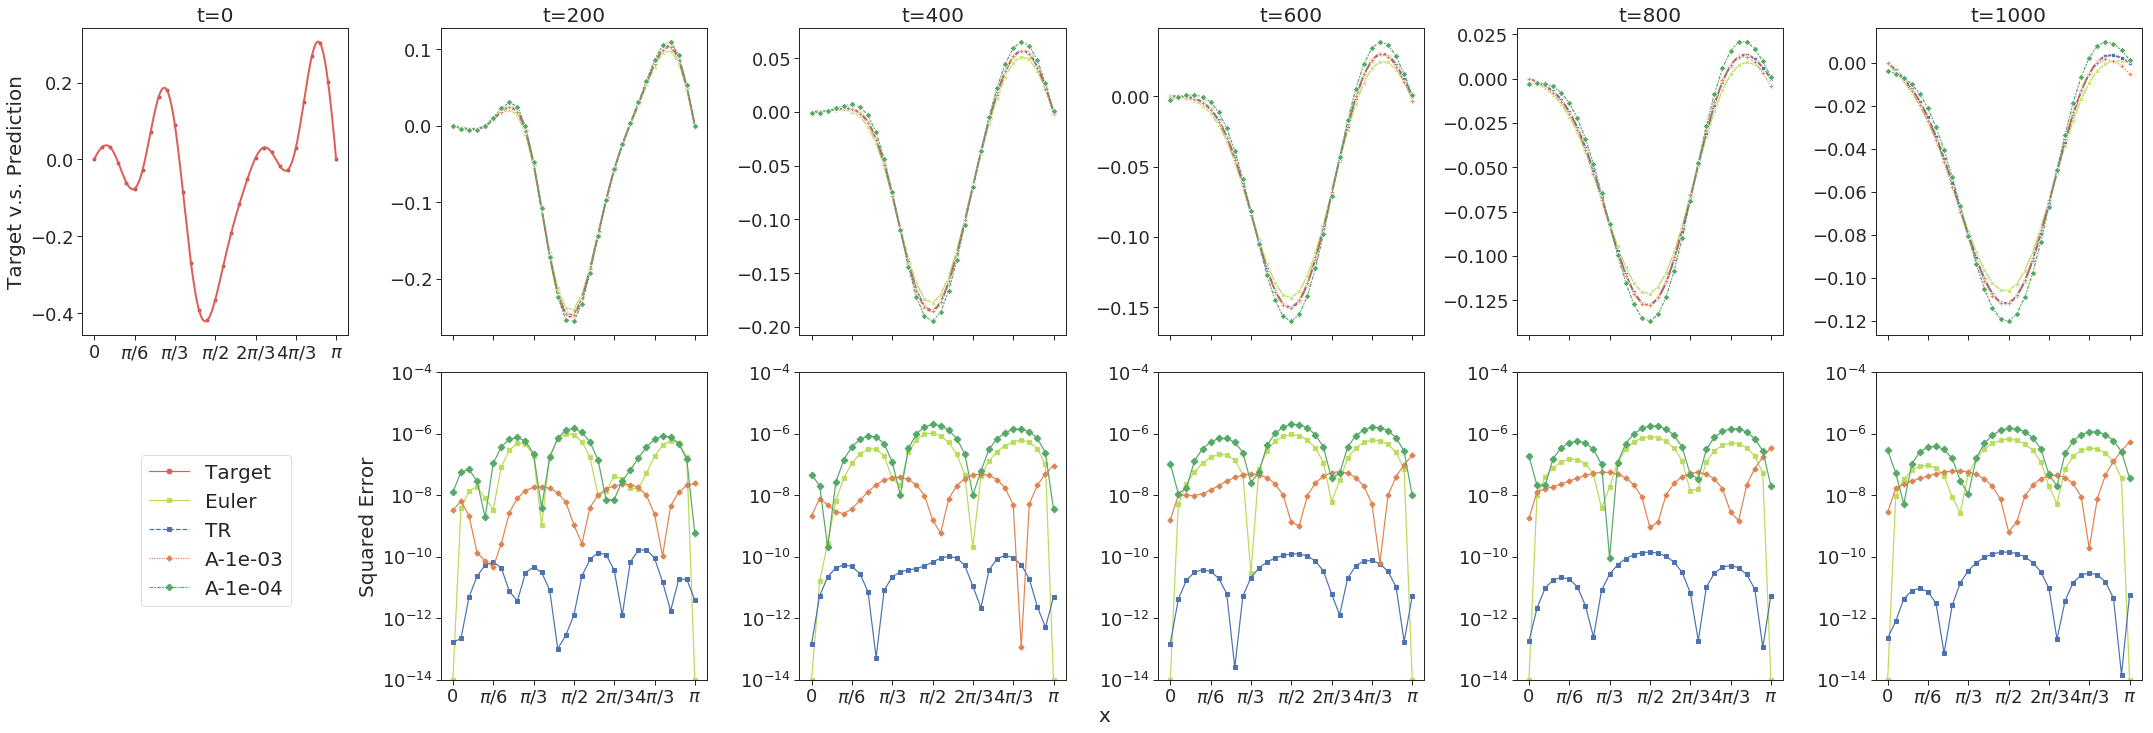

In [12]:
from scipy.interpolate import make_interp_spline, BSpline
sns.set()
sns.set(context="paper",font='serif')
sns.set_style("ticks")

colormap = sns.color_palette("hls", 5)[1:2] + sns.color_palette()[:3]
int_no = 11
xold = range(0,31)
xnew = np.linspace(0,30,30*int_no)

sample = real_signal[0].shape[0]

real_initial = []
real_u = []
for s in [0]:
    
    real_u+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(real_signal[0][s].squeeze(0).cpu().numpy()))]
    temp_u = []
    spl = make_interp_spline(xold, real_signal[0][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
    temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
    real_initial+=temp_u
    
initial_df = pd.DataFrame(data=real_initial,columns=['x',"u(x,0)",'algo'])
real_df = pd.DataFrame(data=real_u,columns=['x',"u(x,0)",''])


fig, ax = plt.subplots(2, 6,figsize=(30,10),sharex=True,sharey=False)
palette = sns.color_palette("hls", 5)[:1]

sns.lineplot(x="x", y="u(x,0)",dashes=[(0,1)],markers=True,markerfacecolor="r",legend=False,\
                     hue="",style="",ci=None,data=real_df,ax=ax[0][0])
sns.lineplot(x="x", y="u(x,0)",dashes=True,lw=2.0,markers=False,palette=palette,legend=False,\
                     hue="algo",style="algo",ci=None,data=initial_df,ax=ax[0][0])


ax[0][0].set_title('t=0',fontdict={'fontsize': 20})
ax[0][0].set_xlabel('x',fontsize=15)

ax[0][0].set_ylabel('Target v.s. Prediction',fontsize=20)
ax[0][0].set_xticks(np.arange(0,31,5))
ax[0][0].set_xticklabels(\
                (0,  '$\pi/6$','$\pi/3$','$\pi/2$', '$2\pi/3$','$4\pi/3$','$\pi$'))
ax[0][0].tick_params(labelbottom=True,labelsize=18)



for t in xrange(len(T_plot)):
    real_u_t=[]
    real_t=[]
    if t == 0:
        LEGEND='full'
    else:
        LEGEND=False
    # first row: target vs prediction
    pred_t = []
    for s in [0]:
        real_u_t+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(real_signal[t+1][s].squeeze(0).cpu().numpy()))]
        temp_u = []
        spl = make_interp_spline(xold, real_signal[t+1][s].squeeze(0).cpu().numpy(), k=3)
        temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
        real_t+=temp_u
        
        pred_t += [[xi,ti,'Euler'] for xi,ti in zip(range(31),list(EU_pred[t][s][0]))]
        pred_t += [[xi,ti,'TR'] for xi,ti in zip(range(31),list(TR_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-03'] for xi,ti in zip(range(31),list(A3_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-04'] for xi,ti in zip(range(31),list(A4_pred[t][s][0]))]
    
    t_df = pd.DataFrame(data=real_t,columns=['x',"u(x,t)",'algo'])
    real_df = pd.DataFrame(data=real_u_t,columns=['x',"u(x,t)",''])
    
    palette = sns.color_palette("hls", 5)[:1]
    sns.lineplot(x="x", y="u(x,t)",dashes=True,lw=2.0,markers=True,markevery=int_no,palette=palette,legend=LEGEND,\
                     hue="algo",style="algo",ci=None,data=t_df,ax=ax[0][t+1])
    sns.lineplot(x="x", y="u(x,t)",dashes=[(0,1)],markers=True,markerfacecolor="r",legend=False,\
                     hue="",style="",ci=None,data=real_df,ax=ax[0][t+1])
    
    pred_t_df = pd.DataFrame(data=pred_t,columns=['x',"u(x,t)",'algo'])
    palette = sns.color_palette("hls", 5)[1:2] + sns.color_palette()[:3]
    
    
    sns.lineplot(x="x", y="u(x,t)",dashes=True,markers=['X','s','P','D'],palette=palette,legend=LEGEND,\
                     hue="algo",style="algo",ci=None,data=pred_t_df,ax=ax[0][t+1])
    ax[0][t+1].set_xlabel('')
    ax[0][t+1].set_ylabel('')
    ax[0][t+1].set_title('t=%s'%T_plot[t],fontdict={'fontsize': 20})
    ax[0][t+1].tick_params(labelsize=18)
    
        
       

    # second row: mean squared error
    target = real_signal[t+1][s:s+1,0,:].cpu().numpy()
    
    trustregion = np.sum((TR_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam3 = np.sum((A3_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam4 = np.sum((A4_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod = np.sum((EU_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod[0]=1e-14
    eulermethod[30]=1e-14
    ax[1][t+1].semilogy(range(31),eulermethod,dashes='',marker="X",c=colormap[0],label='Euler')
    ax[1][t+1].semilogy(range(31),trustregion,dashes='',marker="s",c=colormap[1],label='TR')
    ax[1][t+1].semilogy(range(31),adam3,marker='P',dashes='',c=colormap[2],label='A-1e-03')
    ax[1][t+1].semilogy(range(31),adam4,marker='D',dashes='',c=colormap[3],label='A-1e-04')
    ax[1][t+1].set_ylim([1e-14,1e-4])
    ax[1][t+1].tick_params(labelbottom=True,labelsize=18)
    
ax[1][1].set_ylabel('Squared Error',fontsize=20)
    
ax[1][0].remove()
handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles[1:2]+handles[3:], labels[1:2]+labels[3:], loc='upper center',bbox_to_anchor=(0.1, 0.4),\
           fontsize=20)
ax[0][1].legend().set_visible(False)


fig.tight_layout()
fig.text(0.51, 0.0, 'x', va='center',fontsize=20)
plt.show()

In [13]:
exit(0)